In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

In [30]:
#setting up salary data
sal=pd.concat([pd.read_csv(f"salaries/p_{yr}.csv") for yr in range(2018,2010,-1)])
sal=sal.groupby("name").first()

In [31]:
#Setting up dataframes
eval_data = pd.read_csv("averages_enrol.csv")
eval_data[["term"]]=pd.Categorical(eval_data.term)
eval_data[["section"]]=pd.Categorical(eval_data.section)
#eval_data["response_rate"] = eval_data.num_responses / eval_data.enrolled
#df.replace([np.inf, -np.inf], np.nan)

df=eval_data[eval_data.num_responses>10] # only surveys with >10 responses
df=df.groupby("instructor").filter(lambda x:len(x)>2) # only teachers with >=3 classes
df=pd.merge(df,sal,how='left', left_on=["instructor"],right_on=['name']).drop(['benefits',"section"],axis=1)
df.title.replace(np.nan,"Lecturer",inplace=True)

In [32]:
df_tenure=df.groupby("instructor").mean()
df_tenure["num_taught"]=df.groupby("instructor").size()
df_tenure["title"]=df.groupby("instructor").first()[["title"]]
has_tenure=df_tenure.title.isin(["Professor","Associate Professor"])
titles = df_tenure.title

In [33]:
titles.replace("Lecturer",0,inplace=True)
titles.replace("Assistant Professor",1,inplace=True)
titles.replace("Associate Professor",2,inplace=True)
titles.replace("Professor",3,inplace=True)
titles

instructor
Adam Kolkiewicz        2
Adam Roegiest          0
Adriel Dean-Hall       0
Ahmad Alrefai          0
Ahmed Ayaz Ataullah    0
                      ..
Yongqiang Zhao         0
Yu-Ru Liu              3
Yuying Li              3
Zoran Miskovic         3
shahla Aliakbari       0
Name: title, Length: 352, dtype: int64

# Classifiers
The data was fit onto many different classifiers to take a look at how the classifiers performed and also look at the how the underlying data affects different classifiers. In this project, the classification is a component of the analysis, not the final product of the analysis. 

Classifiers were not picked due to any pattern, but follow the ones introduced in Stat 441. We start with K-Nearest Neighbours, a support vector machine classifier, several tree and boosting methods (Decision tree, Random Forest, Adaboost, XGBoost), followed by some more basic classifiers (Naive Bayes, LDA, QDA, and Logistic Regression)

For a select set of the classifiers (SVC,Random Forest, Decision Tree, XGBoost) 5-fold cross validation grid/random search was used to tune the hyperparameters. The others were left as is using certain default methods as they have relatively few parameters.

Grid search was used to tune the SVC due to the different number of parameters depending on kernel, and random search for the rest. 

In [34]:
#grid search for parameter selection of certain estimators
## SVC grid search
param_grid_SVC = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']}
 ]

SVC_clf = GridSearchCV(SVC(), param_grid_SVC, cv=5,iid=False)

#RF
param_grid_RF =  {'bootstrap': [True, False],
 'max_depth':[10,20,30,40,50],
 'max_features':['auto',None],
 'min_samples_leaf': [1,2,3],
 'min_samples_split': [2,5,10],
 'n_estimators': [200,400,800,1000]}

RF_clf = RandomizedSearchCV(RandomForestClassifier(),param_grid_RF,cv=5,iid=False)

param_grid_DT =  {'criterion': ['gini','entropy'],
  'splitter': ['best','random'],
 'max_depth': [10,20,30,40,50],
 'max_features': ['auto'],
 'min_samples_leaf': [2],
 'min_samples_split': [3]}

DT_clf = RandomizedSearchCV(DecisionTreeClassifier(),param_grid_DT,cv=5,iid=False)

param_grid_xgb = {
    'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8],
    'gamma': [0,1,5],
    'learning_rate': [0.1, 0.05, 0.01],
    'maxdepth': [3],
    'n_estimators': [500]
}

XGB_clf = RandomizedSearchCV(xgb.XGBClassifier(),param_grid_xgb,cv=5,iid=False)


In [35]:
#preparing feats
feats=list(df_tenure.select_dtypes('number').columns)
feats.remove("salary")
feats.remove("title")

#scale data
#standardize the data
X= df_tenure
X=StandardScaler().fit_transform(X[feats])

print(feats)

#set up of names and classifiers 
names = ["Nearest Neighbors", "SVM tuned",
         "Decision Tree", "Random Forest","AdaBoost","XGB",
         "Naive Bayes","LDA","QDA","LogReg"]

classifiers = [
    
    KNeighborsClassifier(10),
    SVC_clf,
    DT_clf,
    RF_clf,
    AdaBoostClassifier(),
    XGB_clf,
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

['organization', 'expl_lvl', 'q_treatment', 'visual', 'oral', 'help', 'interesting', 'overall', 'attendance', 'assign_helpful', 'printed_notes', 'textbook', 'new_material', 'assign_amount', 'hours_outside', 'num_responses', 'enrolled', 'response_rate', 'num_taught']


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,has_tenure,test_size=0.3,random_state=42)

output = pd.DataFrame(index = ['train_error', 'base_line_train', 'test_error','base_line_test', 'score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, baseline_train, test_err,baseline_test, score]
    output[f"{name}"] = output_l
#     print(f"train error: {np.mean(clf.predict(X_train)!=y_train)}")
#     print(f"test error:  {np.mean(clf.predict(X_test)!=y_test)}")
#     print(f"baseline:    {np.mean(has_tenure)}")
#print(output_l)
print(output)

                 Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error               0.247967   0.186992       0.044715       0.000000   
base_line_train           0.406504   0.406504       0.406504       0.406504   
test_error                0.283019   0.264151       0.358491       0.292453   
base_line_test            0.462264   0.462264       0.462264       0.462264   
score                     0.716981   0.735849       0.641509       0.707547   

                 AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error      0.044715  0.158537     0.304878  0.223577  0.134146  0.215447  
base_line_train  0.406504  0.406504     0.406504  0.406504  0.406504  0.406504  
test_error       0.339623  0.330189     0.330189  0.273585  0.264151  0.301887  
base_line_test   0.462264  0.462264     0.462264  0.462264  0.462264  0.462264  
score            0.660377  0.669811     0.669811  0.726415  0.735849  0.698113  


In [38]:
print(output.to_latex())

\begin{tabular}{lrrrrrrrrrr}
\toprule
{} &  Nearest Neighbors &  SVM tuned &  Decision Tree &  Random Forest &  AdaBoost &       XGB &  Naive Bayes &       LDA &       QDA &    LogReg \\
\midrule
train\_error     &           0.247967 &   0.186992 &       0.044715 &       0.000000 &  0.044715 &  0.158537 &     0.304878 &  0.223577 &  0.134146 &  0.215447 \\
base\_line\_train &           0.406504 &   0.406504 &       0.406504 &       0.406504 &  0.406504 &  0.406504 &     0.406504 &  0.406504 &  0.406504 &  0.406504 \\
test\_error      &           0.283019 &   0.264151 &       0.358491 &       0.292453 &  0.339623 &  0.330189 &     0.330189 &  0.273585 &  0.264151 &  0.301887 \\
base\_line\_test  &           0.462264 &   0.462264 &       0.462264 &       0.462264 &  0.462264 &  0.462264 &     0.462264 &  0.462264 &  0.462264 &  0.462264 \\
score           &           0.716981 &   0.735849 &       0.641509 &       0.707547 &  0.660377 &  0.669811 &     0.669811 &  0.726415 &  0.735849 &  

In [9]:
for feat,coef in sorted(zip(feats,classifier.coef_[0]),key=lambda x:abs(x[1]),reverse=True):
        print(f"{feat:<16} {coef:7.4f}") # lasso

expl_lvl         -0.9154
new_material      0.8285
help              0.7818
response_rate     0.7619
assign_amount     0.5744
hours_outside     0.5735
q_treatment      -0.5359
num_responses    -0.5310
organization      0.5269
overall          -0.3670
oral              0.3091
num_taught       -0.3016
printed_notes    -0.3005
visual           -0.2445
assign_helpful   -0.1786
attendance       -0.0930
interesting       0.0755
textbook          0.0698
enrolled          0.0080


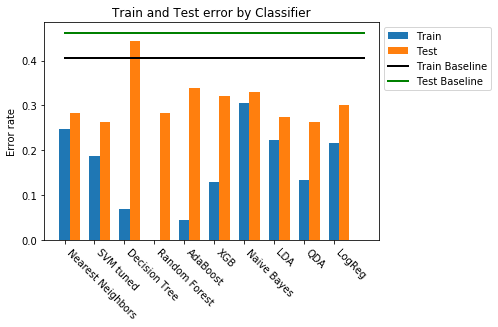

In [10]:
ind = np.arange(10)
p1 = plt.bar(ind,output.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.title('Train and Test error by Classifier')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

Here, we can see that most of the classifiers performed similarly with test error rates between about 0.25 to 0.3. Every classifier was below their baseline. Decision tree classifier performed by far the worst out of all the classifiers and on certain runs is actually very close to the test_baseline value as seen in the plot below. The decision tree's error rates are highly variable. This is unstability is due to small differences in the randomness of the decision tree generating very different trees. The decision trees are also overfit. The most overfit classifier were the random forest classifiers, giving 0 training error. Since we are optimizing max_depth as a parameter of random forest, it will try to pick the largest one as it is more likely to provide a single value within each leaf giving the lowest error. If we are tuning parameters based on error, it might be better to not tune the max_depth value to high values to prevent overfitting.

In [11]:
#decision tree multiple runs
classifier = DT_clf
output_dt = pd.DataFrame(index = ['train_error', 'base_line_train', 'test_error','base_line_test', 'score']) 
for i in range(1,11):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, baseline_train, test_err,baseline_test, score]
    output_dt[f"dt{i}"] = output_l


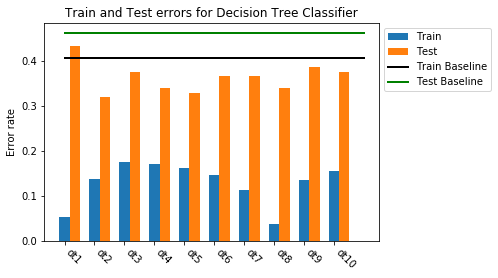

In [12]:
ind = np.arange(10)
p1 = plt.bar(ind,output_dt.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output_dt.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output_dt.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.title('Train and Test errors for Decision Tree Classifier')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

In [13]:
from sklearn.decomposition import PCA
X= df_tenure
X=StandardScaler().fit_transform(X[feats])
X = PCA(.80).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X,has_tenure,test_size=0.3,random_state=42)

output_PCA = pd.DataFrame(index = ['train_error', 'test_error', 'base_line_train','base_line_test', 'score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err, test_err, baseline_train,baseline_test, score]
    output_PCA[f"{name}"] = output_l
#     print(f"train error: {np.mean(clf.predict(X_train)!=y_train)}")
#     print(f"test error:  {np.mean(clf.predict(X_test)!=y_test)}")
#     print(f"baseline:    {np.mean(has_tenure)}")
#print(output_l)
print(output_PCA)

                 Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error               0.252033   0.227642       0.235772       0.073171   
test_error                0.311321   0.330189       0.377358       0.283019   
base_line_train           0.406504   0.406504       0.406504       0.406504   
base_line_test            0.462264   0.462264       0.462264       0.462264   
score                     0.688679   0.669811       0.622642       0.716981   

                 AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error      0.126016  0.182927     0.288618  0.272358  0.276423  0.272358  
test_error       0.292453  0.311321     0.358491  0.301887  0.349057  0.301887  
base_line_train  0.406504  0.406504     0.406504  0.406504  0.406504  0.406504  
base_line_test   0.462264  0.462264     0.462264  0.462264  0.462264  0.462264  
score            0.707547  0.688679     0.641509  0.698113  0.650943  0.698113  


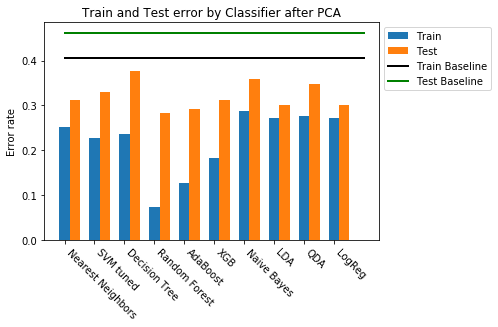

In [14]:
ind = np.arange(10)
p1 = plt.bar(ind,output_PCA.transpose().train_error,width=0.35)
p2 = plt.bar(ind+0.35,output_PCA.transpose().test_error,width=0.35)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind,output_PCA.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.title('Train and Test error by Classifier after PCA')
plt.legend((p1[0], p2[0],l1[0],l2[0]), ('Train', 'Test','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

## Comparing classifiers with their PCA transformed counterparts

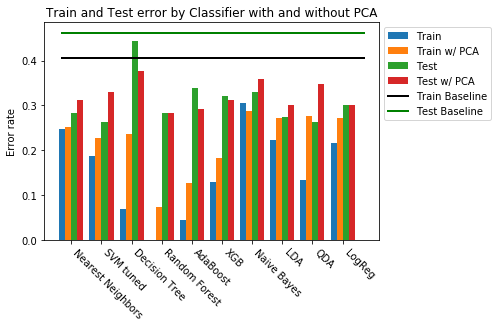

In [15]:
ind = np.arange(10)
wid = 0.2
p1 = plt.bar(ind,output.transpose().train_error,width=wid)
p1_PCA = plt.bar(ind+wid,output_PCA.transpose().train_error,width=wid)
p2 = plt.bar(ind+2*wid,output.transpose().test_error,width=wid)
p2_PCA = plt.bar(ind+3*wid,output_PCA.transpose().test_error,width=wid)
l1 = plt.plot([0,10], [0.406504, 0.406504], 'k-', lw=2)
l2 = plt.plot([0,10], [0.462264, 0.462264], 'g-', lw=2)
plt.xticks(ind+1.5*wid,output_PCA.columns,rotation=-45,ha="left")
plt.ylabel('Error rate')
plt.title('Train and Test error by Classifier with and without PCA')
plt.legend((p1[0], p1_PCA[0],p2[0], p2_PCA[0],l1[0],l2[0]),\
           ('Train', 'Train w/ PCA','Test','Test w/ PCA','Train Baseline','Test Baseline'),loc = "upper left",bbox_to_anchor=[1,1])

Most of the classifiers did not see a decrease in the test error, and some had an increase in test error. Interestingly, the two boosting algorithms managed to achieve lower test error when working with transformed PCA data vs without. 

In [16]:
# ### K-Means?
# from sklearn.cluster import KMeans 
# X= df_tenure
# X=StandardScaler().fit_transform(X[feats])

# reduced_data = PCA(n_components=2).fit_transform(X_train)

# x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
# y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
# xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# X_train, X_test, y_train, y_test = train_test_split(X,has_tenure,test_size=0.3,random_state=42)
# kmeans = KMeans(init='k-means++', n_clusters=2, n_init=20)
# kmeans.fit(reduced_data)

# Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# # Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

# plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# # Plot the centroids as a white X
# centroids = kmeans.cluster_centers_
# plt.scatter(centroids[:, 0], centroids[:, 1],
#             marker='x', s=169, linewidths=3,
#             color='w', zorder=10)


NameError: name 'h' is not defined

With a plot of the two PCA components, we don't see clear separation in the data at all. Both tenure and un-tenured employees are included. This suggests that there does not exist much of a difference in the reviews of the two types of university employees. 

In [17]:
#preparing feats
feats=list(df_tenure.select_dtypes('number').columns)
feats.remove("salary")
feats.remove("title")
#scale data
#standardize the data
X= df_tenure
X=StandardScaler().fit_transform(X[feats])

print(feats)

#set up of names and classifiers 
names = ["Nearest Neighbors", "SVM tuned",
         "Decision Tree", "Random Forest","AdaBoost","XGB",
         "Naive Bayes","LDA","QDA","LogReg"]

classifiers = [
    
    KNeighborsClassifier(10),
    SVC_clf,
    DT_clf,
    RF_clf,
    AdaBoostClassifier(),
    XGB_clf,
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear')]

['organization', 'expl_lvl', 'q_treatment', 'visual', 'oral', 'help', 'interesting', 'overall', 'attendance', 'assign_helpful', 'printed_notes', 'textbook', 'new_material', 'assign_amount', 'hours_outside', 'num_responses', 'enrolled', 'response_rate', 'num_taught']


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,titles,test_size=0.2,random_state=42,stratify=titles)

output = pd.DataFrame(index = ['train_error','test_error','score']) 

for name,classifier in zip(names,classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = [train_err,test_err, score]
    output[f"{name}"] = output_l
#     print(f"train error: {np.mean(clf.predict(X_train)!=y_train)}")
#     print(f"test error:  {np.mean(clf.predict(X_test)!=y_test)}")
#     print(f"baseline:    {np.mean(has_tenure)}")
#print(output_l)
print(output)

             Nearest Neighbors  SVM tuned  Decision Tree  Random Forest  \
train_error           0.323843   0.341637       0.099644       0.081851   
test_error            0.422535   0.338028       0.436620       0.394366   
score                 0.577465   0.661972       0.563380       0.605634   

             AdaBoost       XGB  Naive Bayes       LDA       QDA    LogReg  
train_error  0.352313  0.131673     0.430605  0.352313  0.131673  0.345196  
test_error   0.478873  0.366197     0.507042  0.394366  0.450704  0.366197  
score        0.521127  0.633803     0.492958  0.605634  0.549296  0.633803  


C:\Users\jiach\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [27]:
from sklearn.model_selection import StratifiedShuffleSplit
#output = pd.DataFrame(columns = ['train_error', 'base_line_train', 'test_error','base_line_test', 'score']) 
output = pd.DataFrame(columns = [0,1,2,3,4]) 

classifier= LogisticRegression(solver="newton-cg",multi_class="multinomial")
for i in range(1,1000):
    X_train, X_test, y_train, y_test = train_test_split(X,titles,test_size=0.5,stratify=titles)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test,y_test)
    train_err = np.mean(classifier.predict(X_train)!=y_train)
    test_err = np.mean(classifier.predict(X_test)!=y_test)
    baseline_train = np.mean(y_train)
    baseline_test = np.mean(y_test)
    output_l = pd.DataFrame([train_err, baseline_train, test_err,baseline_test, score]).transpose()
    output = pd.concat([output,output_l])


Text(0, 0.5, 'Test Error')

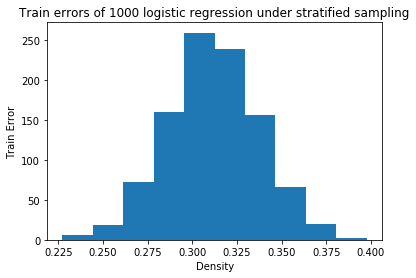

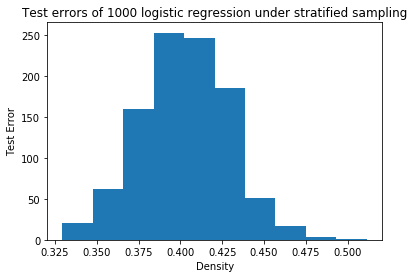

In [28]:
#output
plt.hist(output[0])
plt.title("Train errors of 1000 logistic regression under stratified sampling")
plt.xlabel("Density")
plt.ylabel("Train Error")
plt.figure(0)
plt.hist(output[2],stacked=True)
plt.title("Test errors of 1000 logistic regression under stratified sampling")
plt.xlabel("Density")
plt.ylabel("Test Error")

In [49]:
len(titles[titles == 3])

94